In [504]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

In [505]:
img = imread('ultrassound/cropped/503311001.bmp', as_gray=True)
mask = imread('ultrassound/masks/503311001.bmp')

In [506]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

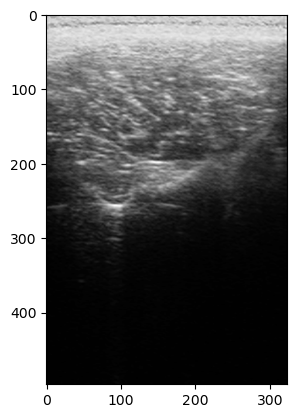

In [507]:
plt.imshow(img, cmap='gray')

## CARREGANDO BASE

In [508]:
from glob import glob
import os

def load_images(DATABASE_PATH, classes):
    database = []
    
    for classe in classes:

        IMAGES_NAME = glob(os.path.join(DATABASE_PATH, classe, '*.bmp'))
    
        imagens = []
        for IMAGE_NAME in IMAGES_NAME:
            imagens.append(imread(IMAGE_NAME, as_gray=True))
            
        database.append(imagens)
    
    return database

In [509]:
DATABASE_PATH = 'ultrassound/'

classes = ['cropped', 'masks']

database = load_images(DATABASE_PATH, classes)

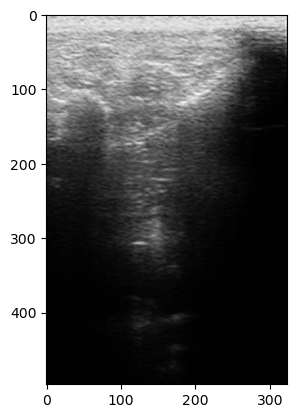

In [518]:
#For example to see the first image of the cropped images
plt.imshow(img, cmap='gray')

# Aplique o algoritmo K-means utilizando os pixels como pesos;

In [500]:
from sklearn.cluster import KMeans

In [520]:
# Apply many KMeans to see the results
def plot_KMeans(img, lmt):
    fig = plt.figure(figsize=(15, 15))
    
    for i in range(lmt[0],lmt[1]):
        fig.add_subplot(3, 3, i)
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(img.reshape(-1,1))
        cluster_assignment = kmeans.predict(img.reshape(-1,1))
        plt.title(f'KMeans for {i} clusters')
        plt.imshow(cluster_assignment.reshape(img.shape), cmap='gray')
    

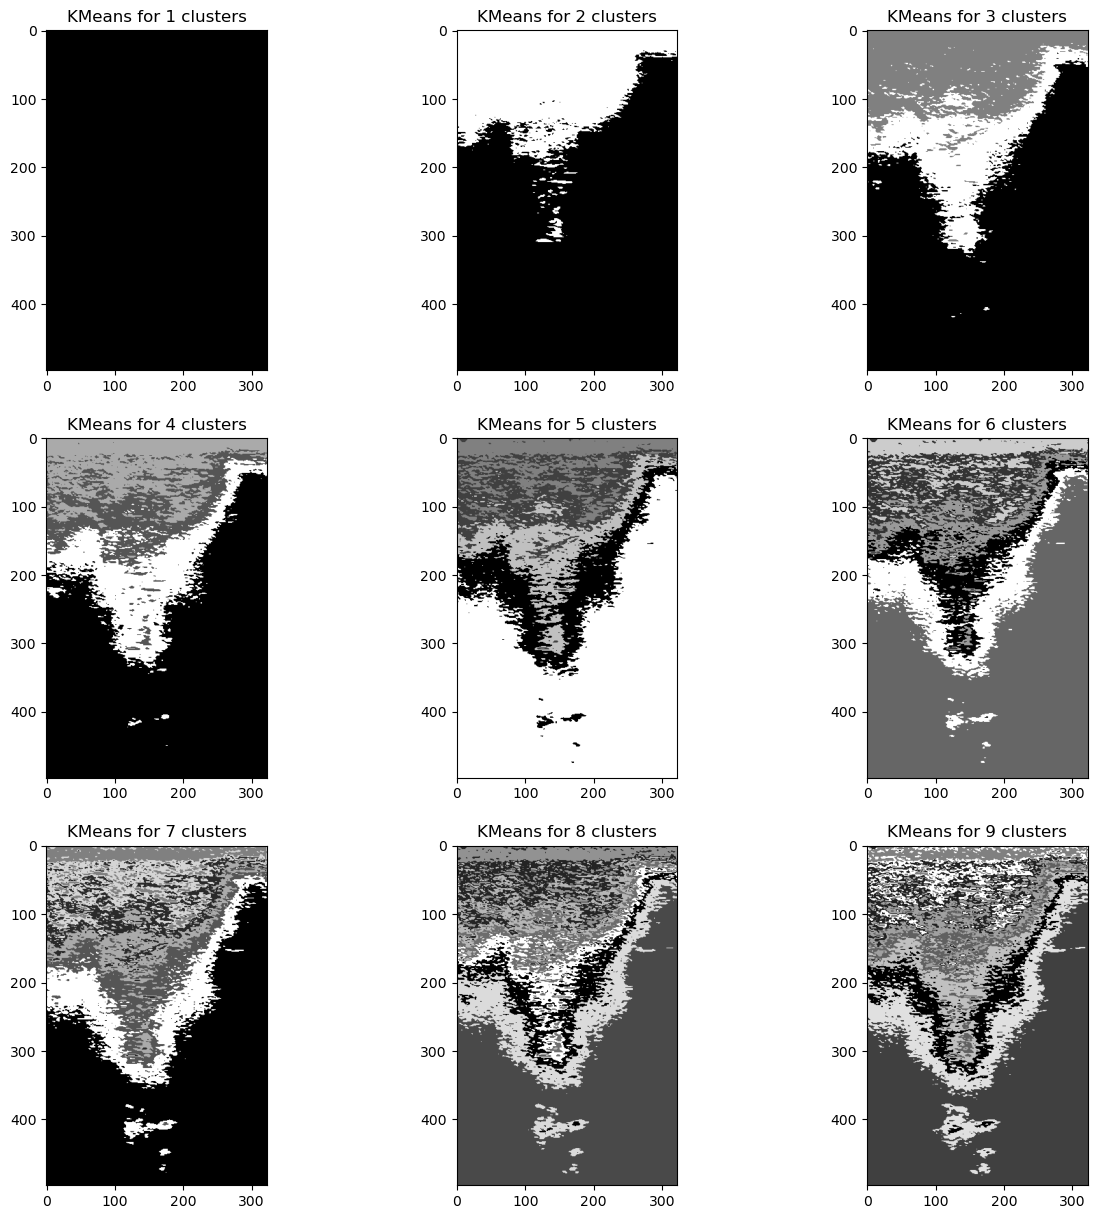

In [521]:
plot_KMeans(img, [1, 10])

In [478]:
# max and min
def retorna_index_foreground_background(cluster_centers: np.ndarray)-> tuple:
    min_value = 99
    min_index = -1
    max_value = -1
    max_index = -1
    for index,cluster_center in enumerate(cluster_centers):
        if min_value > cluster_center:
            min_value = cluster_center
            min_index = index
        if max_value < cluster_center:
            max_value = cluster_center
            max_index = index
    return (min_index,max_index)

[0.42270559]
0
[0.02439959]
1
[0.21520712]
2


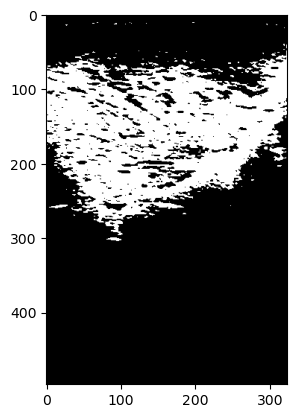

In [475]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(img.reshape(-1,1))
cluster_assignment = kmeans.predict(img.reshape(-1,1))
indices = retorna_index_foreground_background(kmeans.cluster_centers_)
cluster_assignment = (cluster_assignment != indices[0]) & (cluster_assignment != indices[1])
plt.imshow(cluster_assignment.reshape(img.shape), cmap='gray')

In [479]:
def make_kmeans(database, k):
    kmeans = KMeans(k)
    new_database = []
    for img in database[0]:
        kmeans.fit(img.reshape(-1,1))
        cluster_assignment = kmeans.predict(img.reshape(-1,1))
        indices = retorna_index_foreground_background(kmeans.cluster_centers_)
        cluster_assignment = (cluster_assignment != indices[0]) & (cluster_assignment != indices[1])
        new_database.append(cluster_assignment.reshape(img.shape))
    return new_database

In [480]:
kmeans_database = make_kmeans(database, 3)

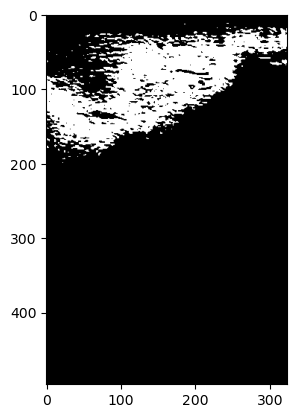

In [483]:
plt.imshow(kmeans_database[2], cmap='gray')

In [392]:
where = np.where(kmeans_database[0] == 1)
print(where)

(array([  0,   0,   0, ..., 308, 308, 308], dtype=int64), array([  0,   1,   2, ..., 131, 132, 133], dtype=int64))


## Implemente duas segmentações utilizando os algoritmos de binarização local e global (Niblack e Otsu, respectivamente);

In [99]:
from skimage.filters import threshold_niblack, threshold_otsu
from functools import partial

In [524]:
# Apply the thresholds to see the results
def make_thresholds(database, funcao=None):
    new_database = []
    for img in database[0]:
        threshold = funcao(img)
        new_database.append(img > threshold)
    return new_database

In [525]:
niblack_database = make_thresholds(database, partial(threshold_niblack, window_size=35, k=0.8))
otsu_database = make_thresholds(database, threshold_otsu)

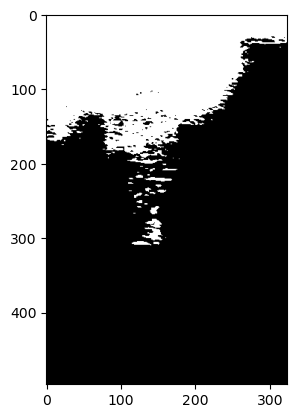

In [526]:
plt.imshow(otsu_database[0], cmap='gray')

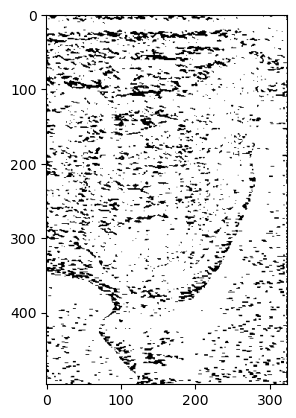

In [522]:
# Apply Niblack only for example
niblack = threshold_niblack(img, window_size=35, k=0.8)
niblack_img = img > niblack
plt.imshow(niblack_img, cmap='gray')

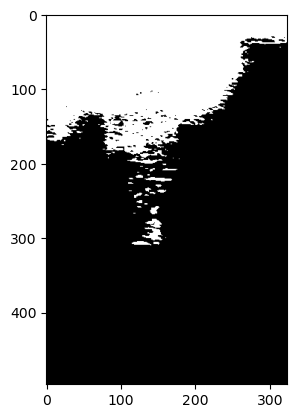

In [523]:
# Apply Otsu only for example
otsu = threshold_otsu(img)
otsu_img = img > otsu
plt.imshow(otsu_img, cmap='gray')

# Aplique   outro   algoritmo   de   agrupamento   que   utilize   também   a   posição espacial dos pixels como peso;
* MeanShift é uma técnica de processamento de imagem e análise de dados que visa encontrar pontos de máxima densidade em um espaço de recursos. É frequentemente usado para agrupar dados, já que ele se move na direção da densidade de dados local até atingir um ponto de convergência. O resultado é um agrupamento de pontos de dados similares baseados na densidade local.

In [528]:
#obs estudar meanshift e seus parametros

In [529]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift, estimate_bandwidth
from matplotlib import pyplot as plt
from skimage.io import imread

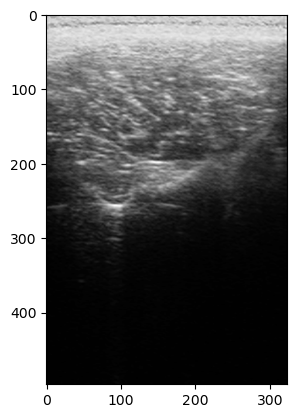

In [537]:
img = imread('ultrassound/cropped/503311001.bmp', as_gray=True)
plt.imshow(img, cmap='gray')

In [538]:
bandwidth = estimate_bandwidth(img.reshape(-1, 1), quantile=0.4, n_samples=100)    
ms = MeanShift(bandwidth = bandwidth, bin_seeding=True)

In [539]:
ms.fit(img.reshape(-1, 1))
labels = ms.labels_
cluster_centers = ms.cluster_centers_

In [540]:
labels.shape
np.unique(labels)

array([0, 1, 2], dtype=int64)

In [541]:
cluster_centers

array([[0.0219396 ],
       [0.2030423 ],
       [0.43908386]])

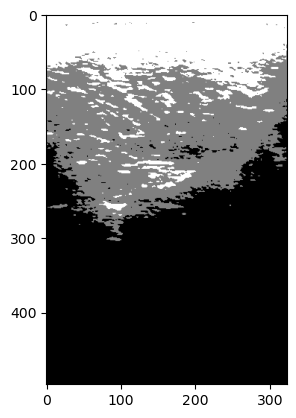

In [542]:
plt.imshow(labels.reshape(img.shape), cmap='gray')

In [543]:
where = np.where(labels == 2)
print(where)

(array([    0,     1,     2, ..., 87308, 87309, 87310], dtype=int64),)


In [544]:
where = np.where(labels == 2)
print(where)
img_changed = labels
img_changed[where] = 0

(array([    0,     1,     2, ..., 87308, 87309, 87310], dtype=int64),)


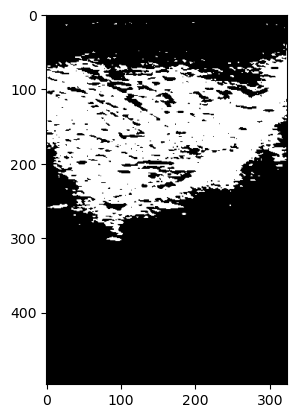

In [545]:
plt.imshow(img_changed.reshape(img.shape), cmap='gray')

In [546]:
def make_meanshift(database):
    new_database = []
    bandwidth = estimate_bandwidth(database[0][0].reshape(-1, 1), quantile=0.4, n_samples=100)
    for img in database[0]:    
        ms = MeanShift(bandwidth = bandwidth, bin_seeding=True, n_jobs = -1)
        ms.fit(img.reshape(-1, 1))
        labels = ms.labels_
        where = np.where(labels == 2)
        labels[where] = 0
        new_database.append(labels.reshape(img.shape))
    return new_database

In [547]:
meanshift_database = make_meanshift(database)

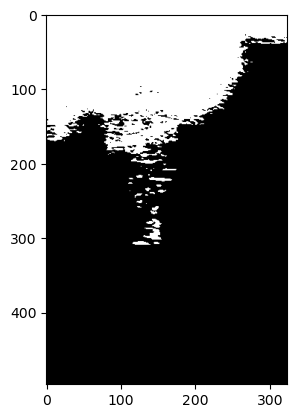

In [548]:
plt.imshow(meanshift_database[0], cmap='gray')

* Pesquise em artigos do estado da arte métricas de acurácia de segmentação. Aplique
pelo menos duas métricas nos resultados de segmentação obtidos. Para isso, utilizem
as imagens na pasta “masks” que estão na base.

* $$\text{Dice}(A,B) = \frac{2|A \cap B|}{|A| + |B|}$$

Onde $A$ e $B$ são conjuntos de dados, e $|A|$ e $|B|$ são suas respectivas cardinalidades (número de elementos). O operador $|A \cap B|$ representa o número de elementos em comum entre os dois conjuntos.

* $$\text{Acurácia} = \frac{\text{VP} + \text{VN}}{\text{VP} + \text{VN} + \text{FP} + \text{FN}}$$

Onde VP é o número de verdadeiros positivos (ou seja, o número de previsões corretas para a classe positiva), VN é o número de verdadeiros negativos (ou seja, o número de previsões corretas para a classe negativa), FP é o número de falsos positivos (ou seja, o número de previsões incorretas para a classe positiva), e FN é o número de falsos negativos (ou seja, o número de previsões incorretas para a classe negativa).

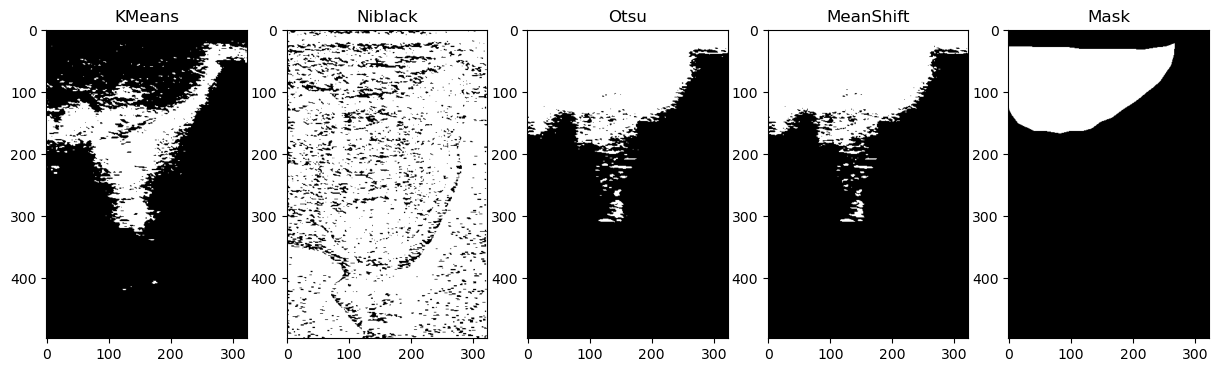

In [549]:
plot = plt.figure(figsize=(15, 15))
plot.add_subplot(1, 5, 1)
plt.imshow(kmeans_database[0], cmap='gray')
plt.title('KMeans')
plot.add_subplot(1, 5, 2)
plt.imshow(niblack_database[0], cmap='gray')
plt.title('Niblack')
plot.add_subplot(1, 5, 3)
plt.imshow(otsu_database[0], cmap='gray')
plt.title('Otsu')
plot.add_subplot(1, 5, 4)
plt.imshow(meanshift_database[0], cmap='gray')
plt.title('MeanShift')
plot.add_subplot(1, 5, 5)
plt.imshow(database[1][0], cmap='gray')
plt.title('Mask');

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


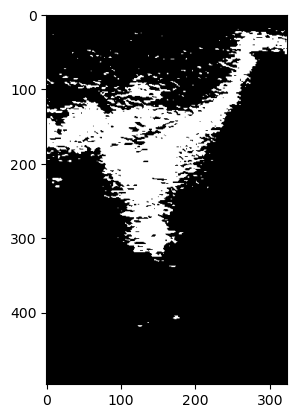

In [550]:
print(kmeans_database[0])
plt.imshow(kmeans_database[0], cmap='gray')

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


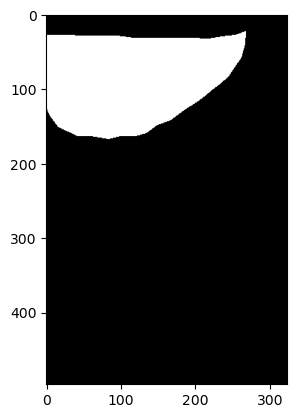

In [551]:
print(database[1][0])
plt.imshow(database[1][0], cmap='gray')

In [552]:
from sklearn.metrics import jaccard_score, f1_score

In [553]:
metrics = {'Dice': partial(f1_score, average = 'micro'), 'IoU': partial(jaccard_score, average = 'micro')}

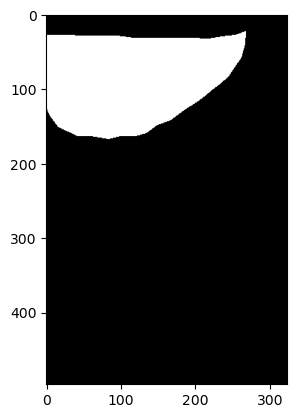

In [554]:
plt.imshow(database[1][0], cmap='gray')

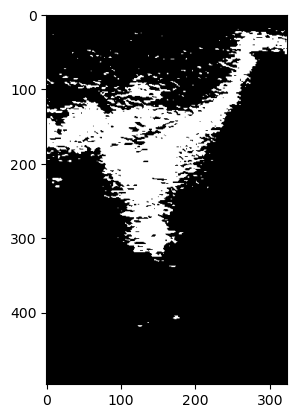

In [555]:
plt.imshow(kmeans_database[0], cmap='gray')

In [557]:
print(metrics['IoU'](kmeans_database[0], database[1][0]))

0.1466554081884834


In [560]:
# Apply the metrics in database to see the results
def make_metrics(database, masks, metrics):
    accs = 0
    results = []
    for metric in metrics:
        for img, mask in zip(database, masks):
            accs += metrics[metric](img.reshape(-1,1), mask.reshape(-1,1))
        results.append(accs/len(database))
        accs = 0
    return results

In [561]:
#Only testing in one database the metrics to see the results
print(make_metrics(kmeans_database, database[1], metrics))

[0.6962049431459051, 0.5393197389627189]


In [563]:
# Apply the metrics in all databases to see the results
def apply_metrics(databases, masks, metrics):
    results = {}
    for database in databases:
        results[database] = make_metrics(databases[database], masks, metrics)
    return results

In [564]:
databases = {'kmeans': kmeans_database, 'niblack': niblack_database, 'otsu': otsu_database, 'meanshift': meanshift_database}

In [565]:
result_all = apply_metrics(databases, database[1], metrics)

In [566]:
for i in result_all:
    print(f'Method: {i}: Dice: {result_all[i][0]} IoU: {result_all[i][1]}')

Method: kmeans: Dice: 0.6962049431459051 IoU: 0.5393197389627189
Method: niblack: Dice: 0.1293812047190716 IoU: 0.06935334128791724
Method: otsu: Dice: 0.6886624686651273 IoU: 0.5293369929997213
Method: meanshift: Dice: 0.7278255181393449 IoU: 0.5793984022131355
